In [60]:
# Import necessary modules first.
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.losses import CategoricalCrossentropy, MeanAbsoluteError, BinaryCrossentropy
import numpy as np
import random
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import warnings 
from tqdm.notebook import tqdm 
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
random.seed(1234)

In [3]:
BATCH_SIZE = 64
EPOCHS = 80
TARGET_SIZE = (128,128)

In [4]:
BASE_DIR = r'D:\ML\mainAgeDec\UTKFace\data'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
    image_path = os.path.join(BASE_DIR, image)
    img_components = image.split('_')
    age_label = int(img_components[0])
    gender_label = int(img_components[1])

    # Append the image_path, age_label, and gender_label
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    image_paths.append(image_path)

  0%|          | 0/47385 [00:00<?, ?it/s]

In [5]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 47385, Number of gender_labels: 47385, Number of image_paths: 47385


In [6]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [7]:
import pandas as pd 
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,D:\ML\mainAgeDec\UTKFace\data\60_0_0_201701171...,60,0
1,D:\ML\mainAgeDec\UTKFace\data\1_1_2_2016121916...,1,1
2,D:\ML\mainAgeDec\UTKFace\data\26_0_1_201701162...,26,0
3,D:\ML\mainAgeDec\UTKFace\data\35_0_2_201701161...,35,0
4,D:\ML\mainAgeDec\UTKFace\data\35_0_1_201701131...,35,0


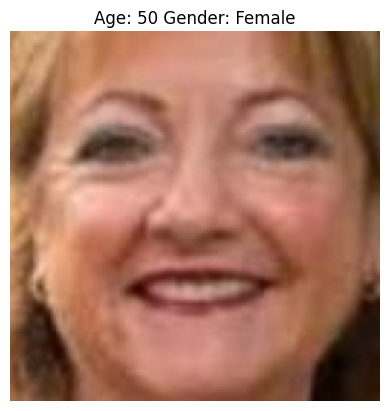

In [8]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

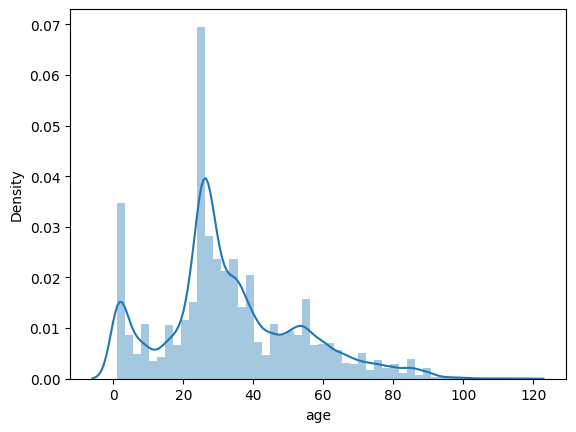

In [9]:
 # Age distribution
sns.distplot(df['age'])

In [10]:
# sns.countplot(df['gender'])

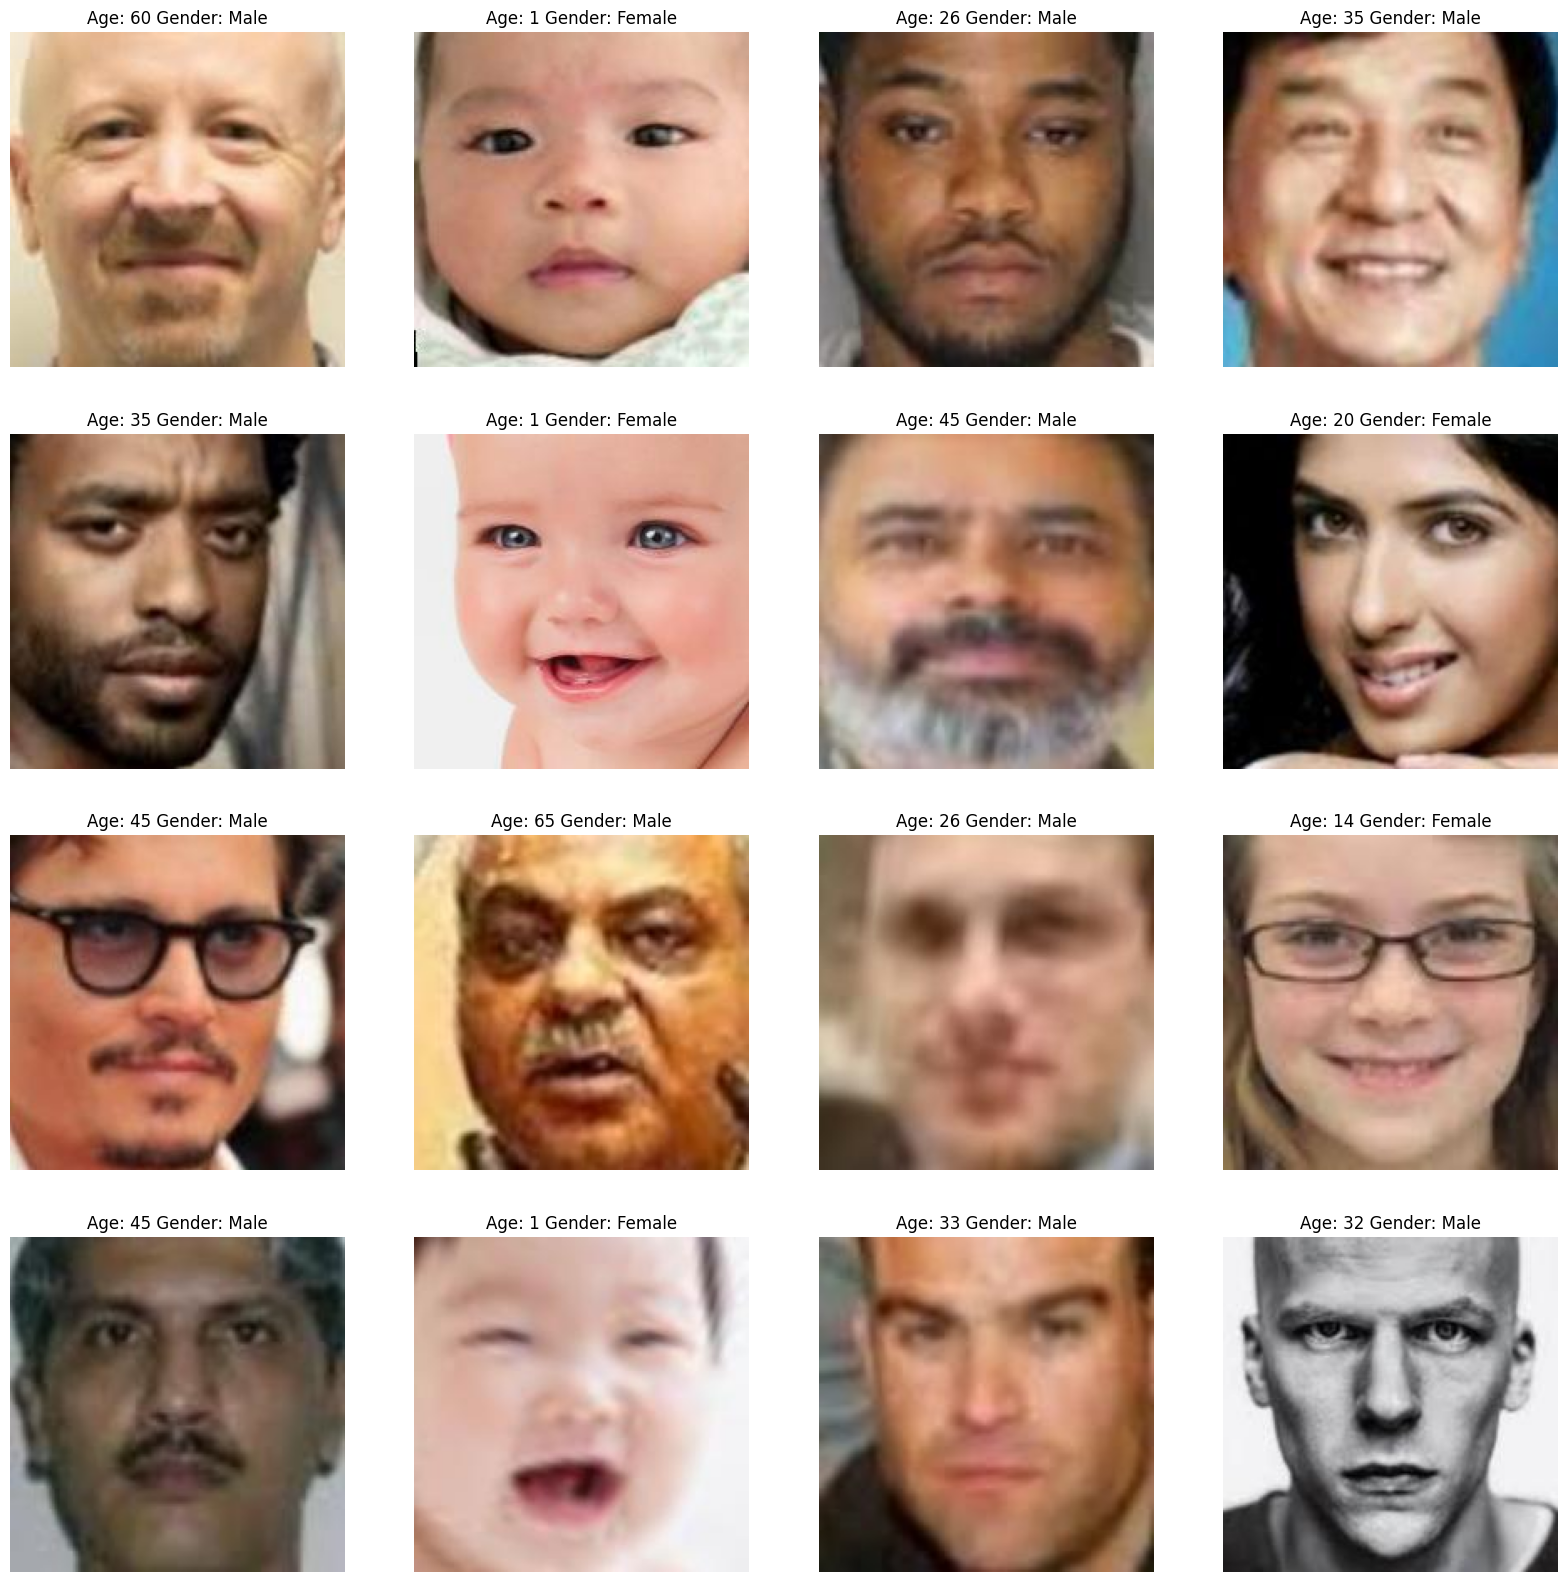

In [11]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

In [12]:
# Import the necessary module from keras
from keras.preprocessing.image import load_img
from PIL import Image

def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, color_mode = "grayscale")
        img = img.resize((128, 128), Image.ANTIALIAS)
        
        # img = load_img(image)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features


X = extract_image_features(df['image_path'])

  0%|          | 0/47385 [00:00<?, ?it/s]

In [13]:
X.shape

(47385, 128, 128, 1)

In [14]:
X = X / 255.0

In [15]:
np.save('combine_dataset.npy', X)

In [16]:
# X = np.load('origin_dataset.npy')
# X.shape

In [17]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [18]:
input_shape = (128, 128, 1)

In [19]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', MeanAbsoluteError()],
              optimizer='adam', metrics=['accuracy','mae'])

In [20]:
# # plot the model
# from tensorflow.keras.utils import plot_model
# plot_model(model)

In [21]:
# To fix the error "module 'pydot' has no attribute 'InvocationException'", you can try the following:

# Install the graphviz package if you haven't already
# You can install it using pip:
# !pip install graphviz

# Then, you can try reinstalling pydot and pydotplus
# !pip uninstall pydot
# !pip uninstall pydotplus
# !pip install pydot
# !pip install pydotplus

# If the issue persists, you can try using a different method to plot the model, such as using matplotlib or saving the model plot to a file.

In [22]:
# model.save_weights('trained_model_weights.weights.h5')

In [23]:
# model.save('trained_model.h5')

In [24]:
class CustomCallBack(tf.keras.callbacks.Callback):
    def __init__(self, threshold, save_path):
        super(CustomCallBack, self).__init__()
        self.threshold = threshold
        self.save_path = save_path
        self.best_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')
        if current_loss is None:
            return
        
        if current_loss < self.best_loss:
            if current_loss < self.threshold:
                self.model.save(self.save_path + f"model_{epoch}_{current_loss}.keras")
                print(f"Model saved at epoch {epoch+1} with loss {current_loss}")
                self.best_loss = current_loss
            else:
                print(f"Loss did not meet the threshold at epoch {epoch+1}. Loss: {current_loss}")

my_callback = CustomCallBack(8, "./")

In [25]:
import gc
gc.collect()

42260

In [26]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size = 32, epochs= 80, validation_split=0.3,
                    callbacks = [my_callback])

Epoch 1/80
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - age_out_mae: 15.2786 - gender_out_accuracy: 0.5825 - loss: 15.9374Loss did not meet the threshold at epoch 1. Loss: 13.616250991821289
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 306s 293ms/step - age_out_mae: 15.2764 - gender_out_accuracy: 0.5826 - loss: 15.9352 - val_age_out_mae: 9.7901 - val_gender_out_accuracy: 0.8010 - val_loss: 10.2332
Epoch 2/80
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - age_out_mae: 9.8280 - gender_out_accuracy: 0.8003 - loss: 10.2529Loss did not meet the threshold at epoch 2. Loss: 9.745134353637695
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 292s 282ms/step - age_out_mae: 9.8276 - gender_out_accuracy: 0.8003 - loss: 10.2525 - val_age_out_mae: 7.8804 - val_gender_out_accuracy: 0.8420 - val_loss: 8.2379
Epoch 3/80
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - age_out_mae: 8.3489 - gender_out_accuracy: 0.8431 - loss: 8.6970Loss did not meet the threshold at epoch 3. Loss: 8.457372665405273
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 287s 

KeyboardInterrupt: 

# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [27]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

if 'gender_out_loss' in history.history:
    loss = history.history['gender_out_loss']
    val_loss = history.history['val_gender_out_loss']

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Loss Graph')
    plt.legend()
    plt.show()
else:
    print("No 'gender_out_loss' found in history.")

NameError: name 'history' is not defined

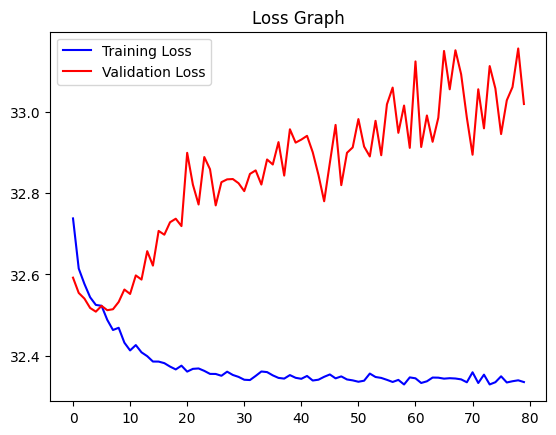

In [ ]:
# plot results for age
# if 'age_out_loss' in history.history:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()
# else:
#     print("No 'age_out_loss' found in history.")

In [35]:
from PIL import Image

def get_image_features(image_path):
    img = Image.open(image_path)
    img = img.resize((128, 128))
    img = np.array(img)
    img = np.expand_dims(img[:, :, 0], axis=-1)  # Keep only one channel for grayscale
    img = img.reshape(1, 128, 128, 1)
    img = img / 255.0
    return img

# from keras.models import load_model

# model = load_model(r'D:\ML\mainAgeDec\model_58_3.1984989643096924.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


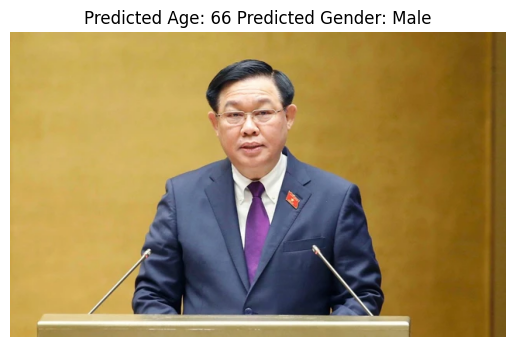

In [37]:
# img_to_test = r'D:\\ML\mainAgeDec\test\vdhue-17141258344601207231487.jpg'
# features = get_image_features(img_to_test)
# pred = model.predict(features)
# gender = gender_mapping[round(pred[0][0][0])]
# age = round(pred[1][0][0])

# plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
# plt.axis('off')
# plt.imshow(np.array(load_img(img_to_test)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


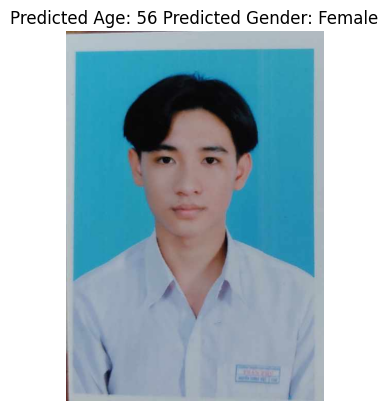

In [62]:
from keras.models import load_model

model = load_model(r'D:\ML\mainAgeDec\use_models\model_58_3.1984989643096924.keras')
img_to_test = r'D:\ML\mainAgeDec\test\tải xuống (8).jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))

vẽ độ thị train 

In [27]:
import re

# Đọc dữ liệu từ file result_train.txt
with open('result_train.txt', 'r', encoding='utf-8') as file:
    data = file.read()

# Tìm tất cả các số trong dữ liệu
numbers = re.findall(r'\d+\.\d+', data)

# Tạo mảng chứa tất cả các số
all_values = []

for i in range(0, len(numbers), 18):
    values = {
        'age_out_mae': float(numbers[i + 3]),
        'gender_out_accuracy': float(numbers[i + 4]),
        'loss': float(numbers[i + 5]),
        'val_age_out_mae': float(numbers[i + 6]),
        'val_gender_out_accuracy': float(numbers[i + 7]),
        'val_loss': float(numbers[i + 8])
    }
    all_values.append(values)

print(all_values)

[{'age_out_mae': 13.616250991821289, 'gender_out_accuracy': 15.2764, 'loss': 0.5826, 'val_age_out_mae': 15.9352, 'val_gender_out_accuracy': 9.7901, 'val_loss': 0.801}, {'age_out_mae': 0.8431, 'gender_out_accuracy': 8.697, 'loss': 8.457372665405273, 'val_age_out_mae': 8.3487, 'val_gender_out_accuracy': 0.8431, 'val_loss': 8.6968}, {'age_out_mae': 8.0399, 'gender_out_accuracy': 7.0501, 'loss': 0.8749, 'val_age_out_mae': 7.331, 'val_gender_out_accuracy': 7.293693542480469, 'val_loss': 7.05}, {'age_out_mae': 6.8816, 'gender_out_accuracy': 0.887, 'loss': 7.1467, 'val_age_out_mae': 6.4986, 'val_gender_out_accuracy': 0.8941, 'val_loss': 6.7502}, {'age_out_mae': 0.8965, 'gender_out_accuracy': 6.5782, 'loss': 6.4888, 'val_age_out_mae': 0.896, 'val_gender_out_accuracy': 6.742, 'val_loss': 6.0644}, {'age_out_mae': 6.049778938293457, 'gender_out_accuracy': 5.7734, 'loss': 0.9077, 'val_age_out_mae': 5.9963, 'val_gender_out_accuracy': 6.1621, 'val_loss': 0.8998}, {'age_out_mae': 0.9196, 'gender_out_

In [28]:
for values in all_values:
    print(values)

{'age_out_mae': 13.616250991821289, 'gender_out_accuracy': 15.2764, 'loss': 0.5826, 'val_age_out_mae': 15.9352, 'val_gender_out_accuracy': 9.7901, 'val_loss': 0.801}
{'age_out_mae': 0.8431, 'gender_out_accuracy': 8.697, 'loss': 8.457372665405273, 'val_age_out_mae': 8.3487, 'val_gender_out_accuracy': 0.8431, 'val_loss': 8.6968}
{'age_out_mae': 8.0399, 'gender_out_accuracy': 7.0501, 'loss': 0.8749, 'val_age_out_mae': 7.331, 'val_gender_out_accuracy': 7.293693542480469, 'val_loss': 7.05}
{'age_out_mae': 6.8816, 'gender_out_accuracy': 0.887, 'loss': 7.1467, 'val_age_out_mae': 6.4986, 'val_gender_out_accuracy': 0.8941, 'val_loss': 6.7502}
{'age_out_mae': 0.8965, 'gender_out_accuracy': 6.5782, 'loss': 6.4888, 'val_age_out_mae': 0.896, 'val_gender_out_accuracy': 6.742, 'val_loss': 6.0644}
{'age_out_mae': 6.049778938293457, 'gender_out_accuracy': 5.7734, 'loss': 0.9077, 'val_age_out_mae': 5.9963, 'val_gender_out_accuracy': 6.1621, 'val_loss': 0.8998}
{'age_out_mae': 0.9196, 'gender_out_accurac

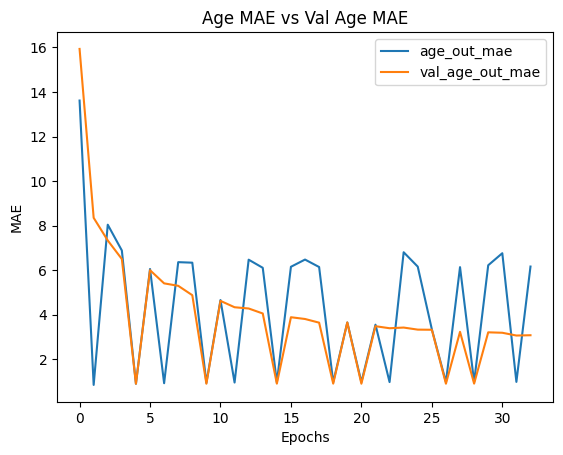

In [29]:
import matplotlib.pyplot as plt

# Extracting the values for plotting
age_out_mae_values = [values['age_out_mae'] for values in all_values]
val_age_out_mae_values = [values['val_age_out_mae'] for values in all_values]

# Plotting age_out_mae vs val_age_out_mae
plt.figure()
plt.plot(age_out_mae_values, label='age_out_mae')
plt.plot(val_age_out_mae_values, label='val_age_out_mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Age MAE vs Val Age MAE')
plt.legend()
plt.show()


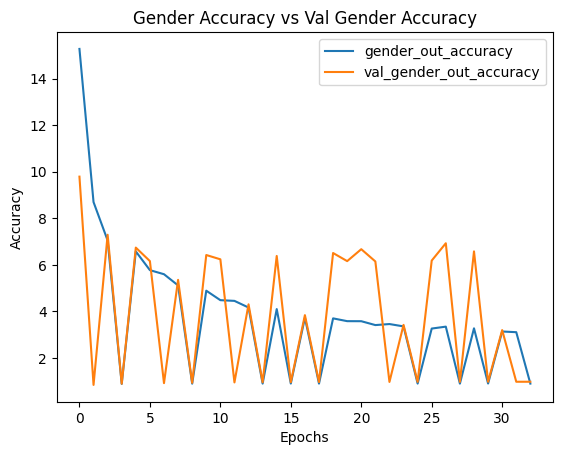

In [30]:
gender_out_accuracy_values = [values['gender_out_accuracy'] for values in all_values]
val_gender_out_accuracy_values = [values['val_gender_out_accuracy'] for values in all_values]

# Plotting gender_out_accuracy vs val_gender_out_accuracy
plt.figure()
plt.plot(gender_out_accuracy_values, label='gender_out_accuracy')
plt.plot(val_gender_out_accuracy_values, label='val_gender_out_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Gender Accuracy vs Val Gender Accuracy')
plt.legend()
plt.show()

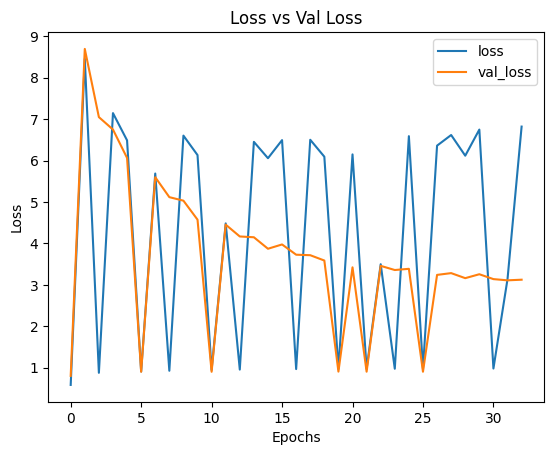

In [31]:
loss_values = [values['loss'] for values in all_values]
val_loss_values = [values['val_loss'] for values in all_values]

# Plotting loss vs val_loss
plt.figure()
plt.plot(loss_values, label='loss')
plt.plot(val_loss_values, label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()